In [12]:
import matplotlib.pyplot as plt
import numpy as np
from kernelcanvas.kernelcanvas2 import KernelCanvas2
import wisardpkg as wp

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [ ]:
MNIST = fetch_openml('mnist_784', version=1, as_frame=False)

In [26]:
# X = MNIST.data[:10000]
# y = MNIST.target[:10000]
X = MNIST.data
y = MNIST.target

X_reshaped = X.reshape(-1, 28, 28)
X_reshaped[0].shape
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [14]:
class KernelCanvas (KernelCanvas2):
    def __init__(self, shape: tuple[int, int], numberOfKernels: int, bitsPerKernel: int = 1, activationDegree: float = 0.07):
        KernelCanvas2.__init__(self, shape, numberOfKernels, bitsPerKernel, activationDegree)
        
    def showCanvas(self):
        canvas = np.ones((*(self.getShape()), 3))  # All white squares, RGB

        # Paint the kernel points red
        for row, col in self.getKernelPoints():
            canvas[row, col] = [1, 0, 0]  # Red color (R=1, G=0, B=0)
        
        fig, ax = plt.subplots()
        ax.imshow(canvas, vmin=0, vmax=1)
        
         # Add numbers to each square
        closest_kernels = self.getClosestKernel()
        for i in range(self.getShape()[0]):
            for j in range(self.getShape()[1]):
                ax.text(j, i, str(closest_kernels[i][j]),
                        va='center', ha='center', color='black', fontsize=6)

        plt.show()
    
    def showTransformed(self, TransformedData):
        if len(TransformedData) != self.getNumberOfKernels():
            raise ValueError(f"Transformed data length {len(TransformedData)} does not match number of kernels {self.getNumberOfKernels()}")

        canvas = np.ones((*(self.getShape()), 3))  # All white squares, RGB

        closest_kernels = self.getClosestKernel()

        # Paint the activated kernels
        for i in range(self.getShape()[0]):
            for j in range(self.getShape()[1]):
                if(TransformedData[closest_kernels[i][j]]):
                    canvas[i, j] = [0, 0, 0]


        # Paint the kernel points red
        for row, col in self.getKernelPoints():
            canvas[row, col] = [1, 0, 0]  # Red color (R=1, G=0, B=0)
            
        fig, ax = plt.subplots()
        ax.imshow(canvas, vmin=0, vmax=1)
        plt.show()
        

In [15]:
kc = KernelCanvas((28, 28), 128)

In [16]:
def drawFig(idx):
    plt.imshow(X_reshaped[idx], cmap='gray')
    plt.title(f"Label: {y[idx]}")
    plt.axis('off')
    plt.show()
    
def accuracy(y_pred, y_target):
  return np.where(y_pred == y_target, 1, 0).sum()/len(y_target)

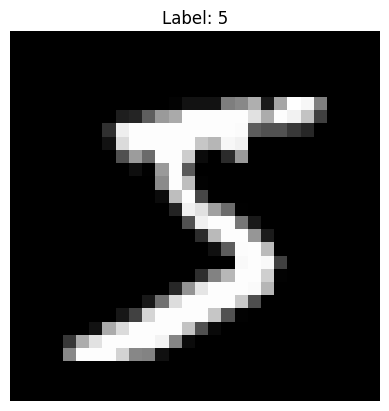

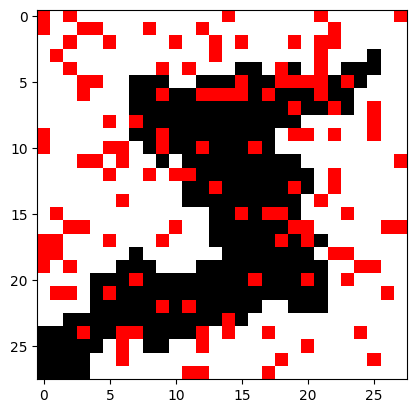

In [17]:
# print(kc.transform(X_reshaped[0]))
drawFig(0)
kc.showTransformed(kc.transform(X_reshaped[0]))

In [27]:
train_points = [kc.transform(x) for x in X_train]
test_points = [kc.transform(x) for x in X_test]

In [28]:
train_ds = wp.DataSet(train_points, y_train)
test_ds = wp.DataSet(test_points, y_test)

In [29]:
model = wp.Wisard(16, verbose=True)
model.train(train_ds)
pred = model.classify(test_ds)
accuracy(pred, y_test)

np.float64(0.7863571428571429)

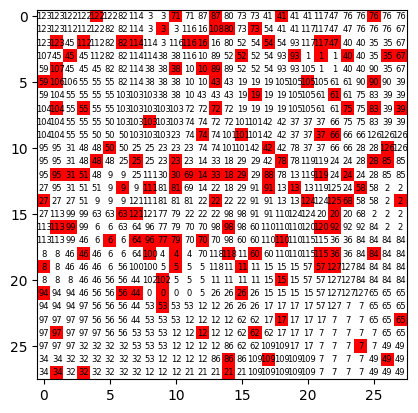

Generation 1
Transformation time: 26.36 seconds
Canvas 1 accuracy: 0.8240714285714286
Canvas 2 accuracy: 0.8284285714285714
Canvas 3 accuracy: 0.828
Canvas 4 accuracy: 0.8252142857142857
Canvas 5 accuracy: 0.8340714285714286
Canvas 6 accuracy: 0.8274285714285714
Canvas 7 accuracy: 0.8287142857142857
Canvas 8 accuracy: 0.8324285714285714
Accuracy generation 1: 0.8340714285714286 (canvas 5)


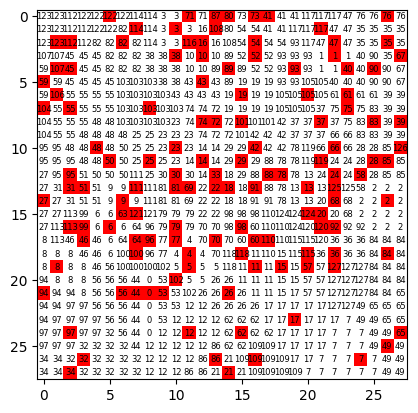

Generation 2
Transformation time: 26.18 seconds
Canvas 1 accuracy: 0.8340714285714286
Canvas 2 accuracy: 0.8194285714285714
Canvas 3 accuracy: 0.8391428571428572
Canvas 4 accuracy: 0.8335
Canvas 5 accuracy: 0.8342142857142857
Canvas 6 accuracy: 0.8327142857142857
Canvas 7 accuracy: 0.8386428571428571
Canvas 8 accuracy: 0.8375
Accuracy generation 2: 0.8391428571428572 (canvas 3)


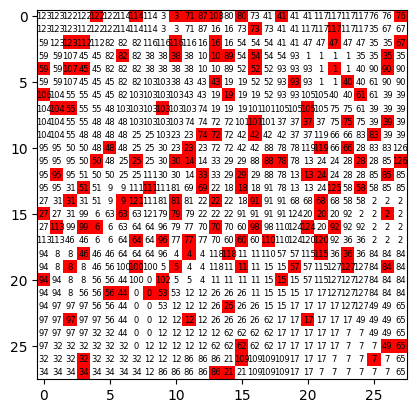

Generation 3
Transformation time: 27.45 seconds
Canvas 1 accuracy: 0.8391428571428572
Canvas 2 accuracy: 0.8287142857142857
Canvas 3 accuracy: 0.8292142857142857
Canvas 4 accuracy: 0.8454285714285714
Canvas 5 accuracy: 0.8429285714285715
Canvas 6 accuracy: 0.832
Canvas 7 accuracy: 0.8422857142857143
Canvas 8 accuracy: 0.845
Accuracy generation 3: 0.8454285714285714 (canvas 4)


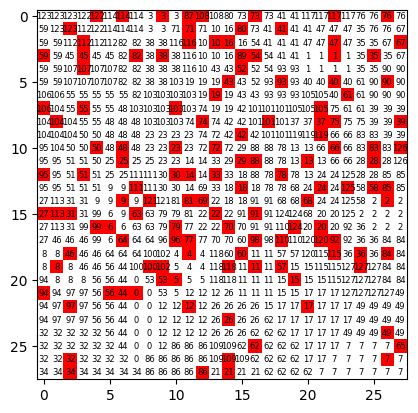

Generation 4
Transformation time: 25.15 seconds
Canvas 1 accuracy: 0.8454285714285714
Canvas 2 accuracy: 0.833
Canvas 3 accuracy: 0.8365
Canvas 4 accuracy: 0.8306428571428571
Canvas 5 accuracy: 0.8317142857142857
Canvas 6 accuracy: 0.8401428571428572
Canvas 7 accuracy: 0.8367857142857142
Canvas 8 accuracy: 0.8390714285714286
Accuracy generation 4: 0.8454285714285714 (canvas 1)


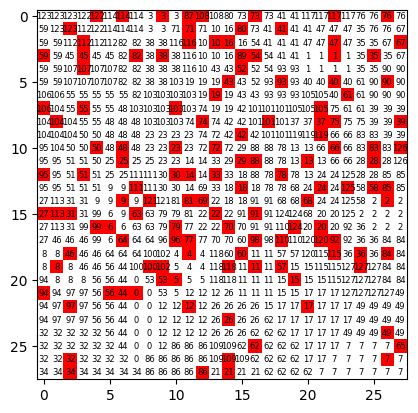

Generation 5
Transformation time: 26.28 seconds


KeyboardInterrupt: 

In [32]:
from multiprocessing import cpu_count
from concurrent.futures import ProcessPoolExecutor
import copy
from time import time

generations = 100
canvas = KernelCanvas((28, 28), 128, bitsPerKernel=1, activationDegree=0.07)
canvas.showCanvas()
model = wp.Wisard(16, verbose=True)


def transform_train(aux : KernelCanvas):
    return [aux.transform(x) for x in X_train]

def transform_test(aux : KernelCanvas):
    return [aux.transform(x) for x in X_test]

for i in range(generations):
    print(f"Generation {i+1}")
    # genePool = [canvas]
    genePool = [copy.deepcopy(canvas) for _ in range(cpu_count())]
    
    for canvas in genePool[1:]:
        canvas.mutateKernel(mutationFactor=np.random.uniform(0.01, 0.5))
    
    for _ in range(cpu_count() - len(genePool)):
        genePool.append(KernelCanvas((28, 28), 128, bitsPerKernel=1, activationDegree=0.07))
    
    transform_start_time = time()
    with ProcessPoolExecutor() as executor:
        train_points_list = list(executor.map(transform_train, genePool))
    with ProcessPoolExecutor() as executor:
        test_points_list = list(executor.map(transform_test, genePool))
    transform_stop_time = time()
    print(f"Transformation time: {transform_stop_time - transform_start_time:.2f} seconds")
    
    train_ds_list = [wp.DataSet(train_points, y_train) for train_points in train_points_list]
    test_ds_list = [wp.DataSet(test_points, y_test) for test_points in test_points_list]

    best_accuracy = 0
    best_model_index = 0
    for j, train_ds in enumerate(train_ds_list):
        model.train(train_ds)
        pred = model.classify(test_ds_list[j])
        acc = accuracy(pred, y_test)
        print(f"Canvas {j+1} accuracy: {acc}")
        if acc > best_accuracy:
            best_accuracy = acc
            best_model_index = j
        model.untrain(train_ds)


    print(f"Accuracy generation {i+1}: {best_accuracy} (canvas {best_model_index+1})")
    canvas = genePool[best_model_index]  # Keep the best canvas for the next generation
    canvas.showCanvas()
    
canvas.showCanvas()